In [171]:
#import modules
import pandas as pd 
import numpy as np
import string
import re
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

#mask warnings
import warnings
warnings.filterwarnings("ignore")

#import our functions
from functions import *
def clean_libelle(libelle):
    libelle = libelle.upper()
    libelle = re.sub(r'[^\w\s]', ' ', libelle)
    libelle = re.sub(r'\s+', ' ', libelle)
    accents = {'É': 'E', 'È': 'E', 'À': 'A'}
    for accent, lettre in accents.items():
        libelle = libelle.replace(accent, lettre)
    libelle = re.sub(r'\bADJ\b', 'ADJOINT', libelle)
    libelle = re.sub(r'\bCL\b', 'CLASSE', libelle)
    libelle = re.sub(r'\bSUP\b', 'SUPERIEUR', libelle)
    libelle = re.sub(r'\bINF\b', 'INFIRMIER', libelle)
    libelle = re.sub(r'\bTEC\b', 'TECHNIQUE', libelle)
    libelle = re.sub(r'\bTECH\b', 'TECHNIQUE', libelle)
    libelle = re.sub(r'\bTECHN\b', 'TECHNIQUE', libelle)
    libelle = re.sub(r'\bADM\b', 'ADMINISTRATIF', libelle)
    libelle = re.sub(r'\bADMI\b', 'ADMINISTRATIF', libelle)
    libelle = re.sub(r'\b1ERE\b', 'PREMIERE', libelle)
    libelle = re.sub(r'\b2EME\b', 'DEUXIEME', libelle)
    libelle = libelle.strip()
    return libelle

#get path
import os
path = os.getcwd()

In [172]:
#df des individus 
df = pd.read_csv(f"{path}/20ksample.csv", encoding='latin-1', low_memory=False)

#clean df and save it
df = df.rename(columns={'LIBELLE_EMPLOI_GRADE': 'libelle', 'EMPLOI_STATUTAIRE':'code'})
df.libelle = df.libelle.astype('category')
df['libelle'] = df['libelle'].apply(clean_libelle)
df.to_csv("clean20K.csv")

#subset 2011
df = pd.read_csv(f"{path}/clean20k.csv", encoding='latin-1', low_memory=False)
df.libelle = df.libelle.astype("str")
df['date_fin'] = pd.to_datetime(df['date_fin'], format='%d/%m/%Y')
df['date_debut'] = pd.to_datetime(df['date_debut'], format='%d/%m/%Y')
df_2011 = df[df['date_debut'] >= '2011-01-01']

In [109]:
#set(df_2011.libelle)

<br>
<br>
<br>
<br>

# Correction des libellés

##### Parmi l'ensemble des individus, après 2011, si un code un présent, alors on va chercher dans la nomenclature le libelle correspondant. Cela a pour objectif d'augmenter le nombre d'individus avec un libellé standardisé.

In [173]:
#open nomenclature
nomenclature = pd.read_csv(f"{path}/nomenclature.csv")
nomenclature = nomenclature.rename(columns={'libelle_NEG_rempl': 'libelle', 'code_NETH_rempl':'code'})
nomenclature['libelle'] = nomenclature['libelle'].apply(clean_libelle)
set_nomenclature = set(nomenclature.libelle)

In [174]:
#remplacer libelle (si code, alors mettre le libelle standardisé)
na1 = df_2011.isna().sum().sum()
df_2011 = remplacer_libelles(df_2011, nomenclature, "code", "libelle")
na2 = df_2011.isna().sum().sum()

#na removed
print(f"Nombre de NaN en moins : {na1-na2}")

Nombre de NaN en moins : 0


<br>
<br>
<br>
<br>

# Approximation des libelle non-standard

##### Parmi les libellés non-standardisés restant, on souhaite, pour tous les individus après 2011, à remplacer par un libellé standardisé. Pour cela, on doit calculer une similarité entre les libellés standardisés et non-standardisés. Pour cela il faut d'abord vectorizer les libellés, nous avons utilisés différentes méthodes :
- Count vectorizer 
- Tfidf vectorizer 
- Hashing vectorizer

##### Méthode de similarité testées :
- [similarité cosinus](https://fr.wikipedia.org/wiki/Similarité_cosinus) (cosinus de l'angle entre 2 vecteurs de dimensions n)

In [175]:
#random sample from the df with the observations
n = 1000
non_standard_labels = list(df_2011.libelle.sample(n))
standard_labels = list(set_nomenclature)
corpus = non_standard_labels + standard_labels
print(f"Shape de NSL={len(non_standard_labels)}")
print(f"Shape de SL={len(standard_labels)}")
print(f"Shape de Corpus={len(corpus)}")

Shape de NSL=1000
Shape de SL=8613
Shape de Corpus=9613


In [176]:
#define a vectorizer
vectorizer1 = CountVectorizer()
vectorizer2 = TfidfVectorizer()
vectorizer3 = HashingVectorizer()
X_non_standard = vectorizer2.fit_transform(non_standard_labels)
X_standard = vectorizer2.transform(standard_labels)

In [181]:
similarity_matrix = cosine_similarity(X_non_standard, X_standard)
most_similar_labels = []
for i in range(len(non_standard_labels)):
    most_similar_index = similarity_matrix[i].argmax()
    most_similar_label = standard_labels[most_similar_index]
    most_similar_labels.append(most_similar_label)
    print(f"{non_standard_labels[i]} --> {most_similar_label}")
    if i > 5:
        break

ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE ECH 5 ECH C2 --> ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE ECH 5 ECH C2
REDACTEUR PRINCIPAL DE PREMIERE CLASSE TROISIEME GRADE --> REDACTEUR PRINCIPAL DE PREMIERE CLASSE TROISIEME GRADE
AGENT DE MAITRISE PRINCIPAL --> AGENT DE MAITRISE PRINCIPAL
AGENT DE MAITRISE --> AGENT DE MAITRISE
INFIRMIER EN SOINS GENERAUX ET SPECIALISES QUATRIEME GRADE --> INFIRMIER EN SOINS GENERAUX ET SPECIALISES QUATRIEME GRADE
ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE DES ETABLISSEMENTS D ENSEIGNEMENT ECH 5 ECH C2 --> ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE DES ETABLISSEMENTS D ENSEIGNEMENT ECH 5 ECH C2
ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE ECH 5 ECH C2 --> ADJOINT TECHNIQUE PRINCIPAL DE DEUXIEME CLASSE ECH 5 ECH C2


<br>
<br>
<br>
<br>

# Remplissage indice brut

<AxesSubplot:xlabel='date_debut', ylabel='INDICE_BRUT'>

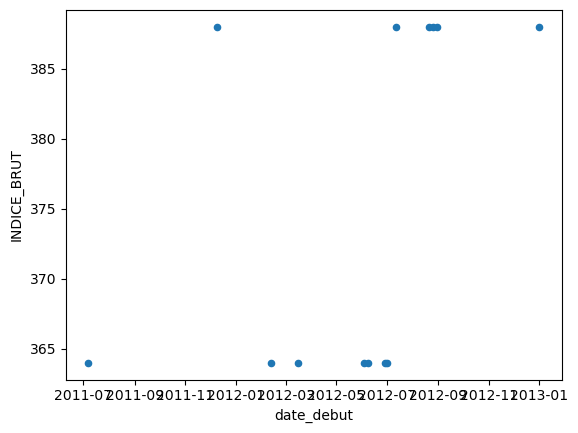

In [ ]:
df_IBna = df_2011[df_2011.INDICE_BRUT.isna()]
df_IBna.ID_CARRIERE.value_counts()
df_2011[df_2011.ID_CARRIERE==800094].plot("date_debut","INDICE_BRUT",kind="scatter")